# Identifying Key Predictors of Voluntary Employee Turnover - Modeling and Evaluation
*By Sophia Jensen and Duy Nguyen | July 2025*
<br> This notebooks is used for model training and evaluation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

from sklearn.model_selection import train_test_split

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Connect to database
#conn = sqlite3.connect("/Users/duynguyen/Documents/Documents - DUY’s Mac mini/GitHub/ADS599_CapstoneProject/data/fevs_data_cleaned.db")
conn = sqlite3.connect("/Users/sophie/Downloads/ADS599_CapstoneProject/data/fevs_data_cleaned.db") # sophia's path
# Cleaned SELECT query
query = """
SELECT year, dsex, deduc, dfedten, dsuper, dminority, dleaving,
       q1, q2, q3, q4, q5, q6, q7, q8, q9, q10,
       q11, q12, q13, q14, q17, q18, q19, q20,
       q21, q22, q23, q24, q25, q26, q27, q28, q29, q30,
       q31, q32, q33, q34, q35, q36, q37, q38
FROM fevs_cleaned_all_years
WHERE dleaving IS NOT NULL;
"""

# Load data
df = pd.read_sql(query, conn)
conn.close()

# Preview results
df.head(20)

,year,dsex,deduc,dfedten,dsuper,dminority,dleaving,q1,q2,q3,...,q29,q30,q31,q32,q33,q34,q35,q36,q37,q38
0,2018,A,B,A,A,A,A,4.0,4.0,4.0,...,4,3,3,X,None,X,4,4,X,X
1,2018,A,B,A,A,B,C,2.0,3.0,4.0,...,2,2,4,2,4,4,4,2,3,3
2,2018,A,B,A,A,A,A,4.0,4.0,5.0,...,4,4,5,5,4,3,5,4,5,4
3,2018,A,A,A,A,B,B,3.0,2.0,3.0,...,3,3,3,3,2,3,4,4,4,4
4,2018,A,C,A,A,B,B,5.0,4.0,4.0,...,5,5,5,5,5,5,5,5,5,5
5,2018,B,A,B,A,B,B,2.0,1.0,2.0,...,3,2,3,3,2,2,1,4,1,1
6,2018,A,B,A,A,B,A,2.0,5.0,5.0,...,4,3,4,4,2,4,4,4,5,5
7,2018,A,B,A,A,B,A,4.0,4.0,4.0,...,4,4,4,4,4,4,4,4,4,4
8,2018,A,B,A,B,B,A,5.0,4.0,4.0,...,5,5,4,4,4,4,4,4,4,5
9,2018,B,C,B,A,B,D,2.0,4.0,4.0,...,4,4,4,4,2,4,4,4,4,4


In [3]:
# identify Likert scale columns
likert_columns = [col for col in df.columns if col.startswith('q')]

# Convert Likert columns to float 
df[likert_columns] = df[likert_columns].apply(pd.to_numeric, errors='coerce')

In [4]:
# Recode float values (1.0–3.0 → 0, 4.0–5.0 → 1)
df[likert_columns] = df[likert_columns].applymap(
    lambda x: 0 if 1.0 <= x <= 3.0 else 1 if 4.0 <= x <= 5.0 else x
)

In [5]:
def to_binary(x):
    try:
        x = float(x)  # handles string numbers like '4.0'
        if 1.0 <= x <= 3.0:
            return 0
        elif 4.0 <= x <= 5.0:
            return 1
        else:
            return x  
    except:
        return x  # keeps NaN or non-numeric values

df[likert_columns] = df[likert_columns].applymap(to_binary)

In [6]:
# deal with missing values
# convert rows with NaN in Likert columns to 1
df[likert_columns] = df[likert_columns].fillna(1)  # Assuming 1 is the neutral value

# check missing values
missing_values = df[likert_columns].isnull().sum()
print("Missing values in Likert columns:")
print(missing_values)

Missing values in Likert columns:
q1     0
q2     0
q3     0
q4     0
q5     0
q6     0
q7     0
q8     0
q9     0
q10    0
q11    0
q12    0
q13    0
q14    0
q17    0
q18    0
q19    0
q20    0
q21    0
q22    0
q23    0
q24    0
q25    0
q26    0
q27    0
q28    0
q29    0
q30    0
q31    0
q32    0
q33    0
q34    0
q35    0
q36    0
q37    0
q38    0
dtype: int64


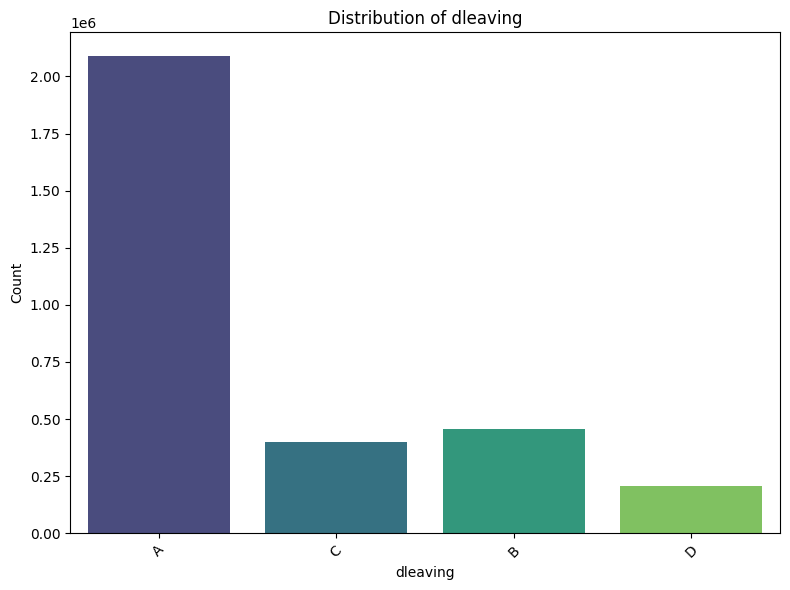

In [6]:
# See distribution of dleaving
plt.figure(figsize=(8, 6))
sns.countplot(x='dleaving', data=df, palette='viridis')
plt.title('Distribution of dleaving')
plt.xlabel('dleaving')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()


There is a class imbalance. Changing the target column to binary where A = Stay and B/C/D = Leaving. Then use SMOTE to oversample to minimize the gap between the classes.

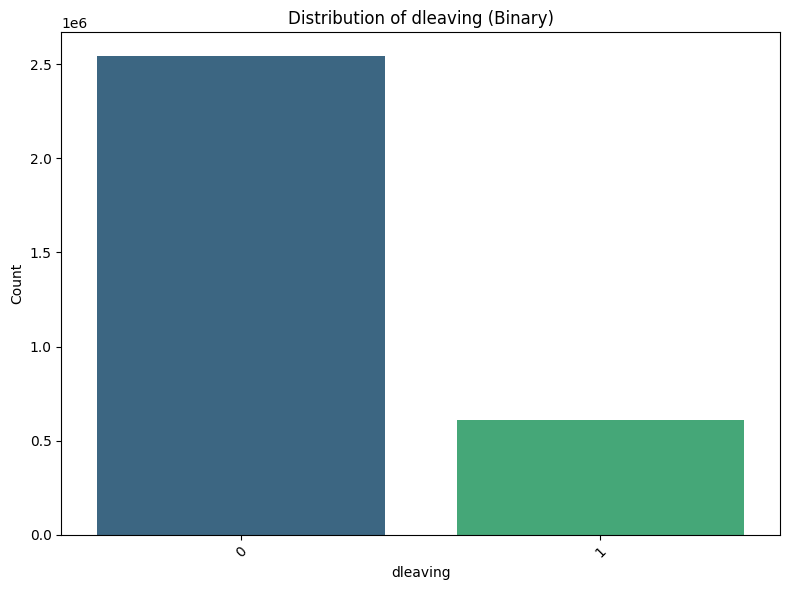

In [7]:
# Make dleaving binary where A/B = 0, C/D = 1
df['dleaving'] = df['dleaving'].apply(lambda x: 0 if x in ['A', 'B'] else 1)
# Check the distribution of dleaving after conversion
plt.figure(figsize=(8, 6))
sns.countplot(x='dleaving', data=df, palette='viridis')
plt.title('Distribution of dleaving (Binary)')
plt.xlabel('dleaving')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()


Binary classification: A/B = 0 (Stay), C/D = 1 (Leave)

In [8]:
# Split the data into training and testing sets
# Define features and target
X = df[likert_columns]
y = df['dleaving']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Balance the training set using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

Training set shape: (2521731, 36) (2521731,)
Testing set shape: (630433, 36) (630433,)


## Logistic Regression


In [12]:
# Build logistic regression model as a baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Fit logistic regression on balanced training data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_bal, y_train_bal)


# Predict on test set
y_pred = logreg.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stay (A/B)', 'Leave (C/D)']))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

  Stay (A/B)       0.82      0.83      0.82    509121
 Leave (C/D)       0.23      0.22      0.22    121312

    accuracy                           0.71    630433
   macro avg       0.52      0.52      0.52    630433
weighted avg       0.70      0.71      0.71    630433

Accuracy: 0.7089143493440223


## Random Forest 


Random Forest Classification Report:
              precision    recall  f1-score   support

  Stay (A/B)       0.82      0.81      0.81    509121
 Leave (C/D)       0.22      0.23      0.23    121312

    accuracy                           0.70    630433
   macro avg       0.52      0.52      0.52    630433
weighted avg       0.70      0.70      0.70    630433

Random Forest Accuracy: 0.696283348111536


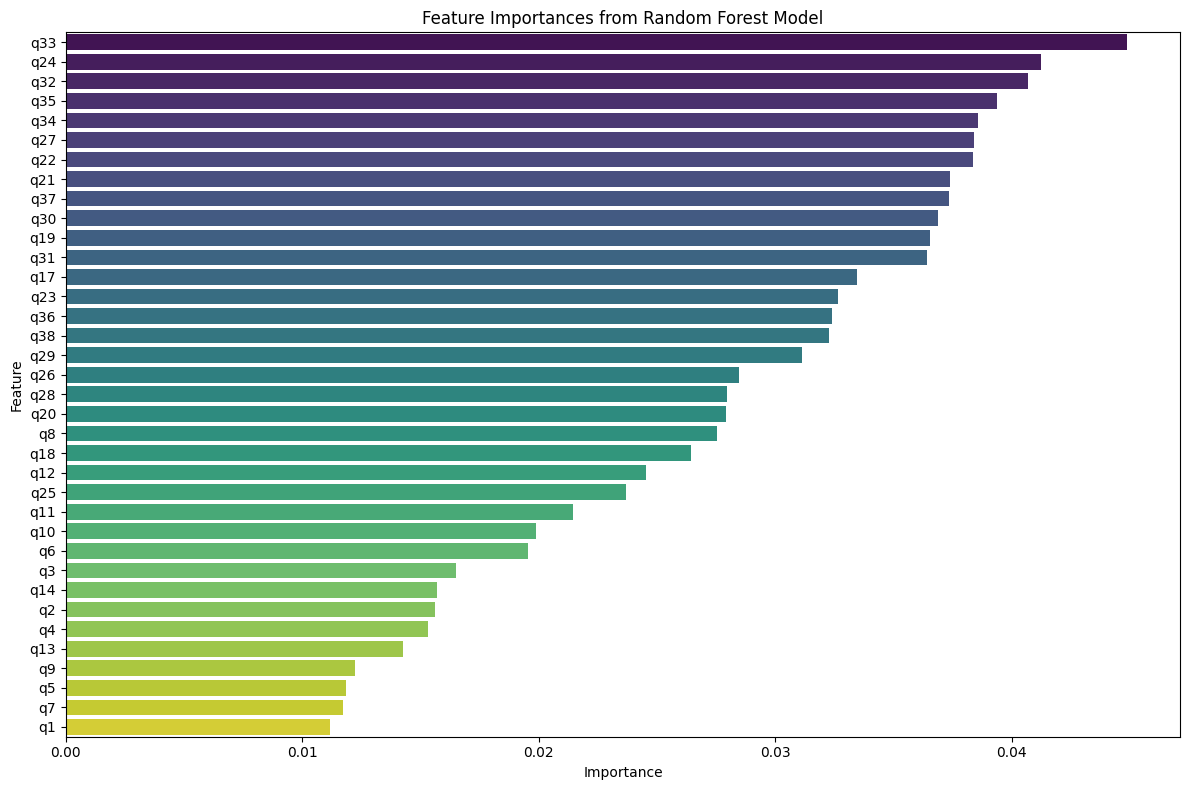

In [13]:
# build random forest model
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest on balanced training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Stay (A/B)', 'Leave (C/D)']))

# Accuracy for Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Feature importance for Random Forest
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()



## XGBoost 


XGBoost Classification Report:
              precision    recall  f1-score   support

  Stay (A/B)       0.82      0.85      0.83    509121
 Leave (C/D)       0.23      0.19      0.21    121312

    accuracy                           0.72    630433
   macro avg       0.52      0.52      0.52    630433
weighted avg       0.70      0.72      0.71    630433

XGBoost Accuracy: 0.7241134268034827


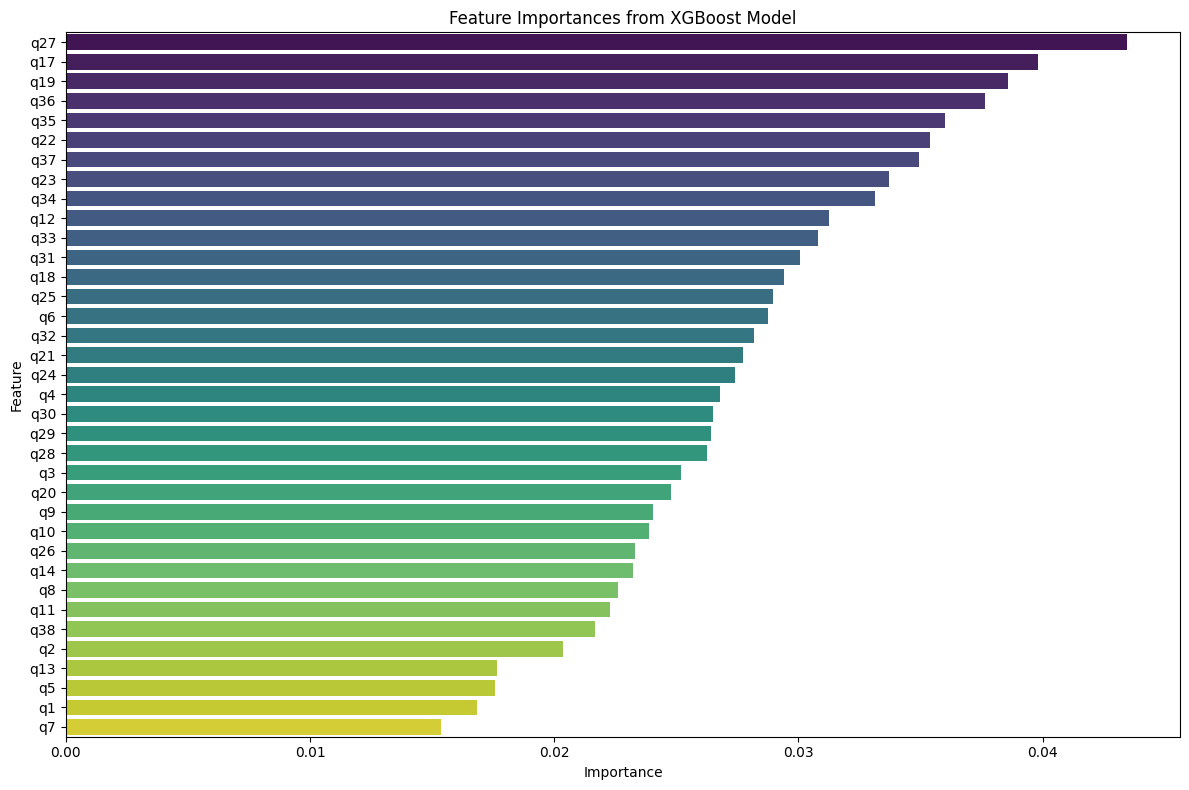

In [16]:
# Build XGBoost model
import xgboost as xgb

# Fit XGBoost on balanced training data
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Classification report for XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Stay (A/B)', 'Leave (C/D)']))

# Accuracy for XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Feature importance for XGBoost
importances_xgb = xgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train_bal.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for XGBoost
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb, palette='viridis')
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
